In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data/taxi_dataset.csv')

In [3]:
data.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N


<dl>
<dt> Описание колонок:
<dd>id - ID поездки </dd>
<dd>vendor_id - ID компании, осуществляющей перевозку </dd>
<dd>pickup_datetime - Таймкод начала поездки</dd>
<dd>dropoff_datetime - Таймкод конца поездки </dd>
<dd>passenger_count - Количество пассажиров </dd>
<dd>pickup_longitude - Долгота точки, в которой началась поездка </dd>
<dd>pickup_latitude - Широта точки, в которой началась поездка </dd>
<dd>dropoff_longitude - Долгота точки, в которой закончилась поездка </dd>
<dd>dropoff_latitude - Широта точки, в которой закончилась поездка </dd>
<dd>store_and_fwd_flag - Yes/No: Была ли информация сохранена в памяти транспортного средства из-за потери соединения с сервером </dd>
</dl>

**Целевая переменная - длительность поездки.**

Зная тайм-коды времени начала и конца поездок, можем вычислить обозначенный таргет.
Договоримся, что производим вычисления в секундах.

Положим таргетную переменнул в столбик с названием _trip_duration_


In [4]:
# приведем pickup_datetime и dropoff_datetime к типу datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [5]:
# добавим столбец - таргет
data['trip_duration'] = (data['dropoff_datetime'] -
                         data['pickup_datetime']).dt.total_seconds()

In [6]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435.0


Предсказывая таргет для новых объектов в будущем, мы не будем заранее знать **dropoff_datetime**.

Удалим колонку из датасета.


In [7]:
data = data.drop('dropoff_datetime', axis=1)

Рассмотрим имеющиеся вещественные/бинарные признаки и решим, какие простейшие признаки можно вытащить из остальных колонок.

Во-первых, имеем бинарный признак `vendor_id`, принимающий значения {1, 2}. Переведем его во множество {0, 1}.


In [8]:
data['vendor_id'] = data['vendor_id'] - 1

Также закодируем бинарный признак `store_and_fwd_flag`. 'N' - 0, 'Y' - 1.


In [9]:
data['store_and_fwd_flag'] = data['store_and_fwd_flag'].apply(
    lambda x: 0 if x == 'N' else 1)

Во-вторых, можем использовать долготу и широту точек старта/завершения поездки, чтобы примерно оценить расстояние между 2 точками.

Базовая идея состоит в том, чтобы посчитать разность долгот и широт соответственно, то есть:

$$
\delta_{long} = \text{dropoff\_longitude} - \text{pickup\_longitude}
$$

$$
\delta_{lat} =  \text{dropoff\_latitude} - \text{pickup\_latitude}
$$

А потом вычислить географическое расстояние между 2 точками по теореме Пифагора:

$$
R = \sqrt{\delta^2_{long} + \delta^2_{lat}}
$$

Мы реализуем данную задумку и вычислим вещественную колонку _R_.

Только для начала нужно некоторым образом перевести долготу и широту в километры, обеспечив равенство их мер измерения. Потому что, вообще говоря, **градусная мера** широт и долгот имеет неодинаковую шкалу перевода в километры.


Начнем переводить каждую долготу в некоторое относительно километровое выражение. Соберем список из всех широт и посчитаем медиану


In [10]:
medianLat = pd.concat(
    [data['pickup_latitude'], data['dropoff_latitude']]).median()
medianLat

40.75431823730469

Теперь, из каждого значения широты вычтем медианное значение.

Результат переведем в километры.


In [11]:
latMultiplier = 111.32

data['pickup_latitude'] = latMultiplier * (data['pickup_latitude'] - medianLat)
data['dropoff_latitude'] = latMultiplier * \
    (data['dropoff_latitude'] - medianLat)

Итого, для **latitude** колонок получили следующие выражения:

_На сколько примерно километров севернее или южнее (в зависимости от знака) точка находится относительно средней широты_


In [12]:
medianLong = pd.concat(
    [data['pickup_longitude'], data['dropoff_longitude']]).median()

longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

In [13]:
data['pickup_longitude'] = longMultiplier * \
    (data['pickup_longitude'] - medianLong)
data['dropoff_longitude'] = longMultiplier * \
    (data['dropoff_longitude'] - medianLong)

In [14]:
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,1,2016-03-14 17:24:55,1,-0.110015,1.516008,1.367786,1.256121,0,455.0
1,id2377394,0,2016-06-12 00:43:35,1,0.036672,-1.753813,-1.571088,-2.578912,0,663.0
2,id3858529,1,2016-01-19 11:35:24,1,0.153763,1.070973,-2.064547,-4.923841,0,2124.0
3,id3504673,1,2016-04-06 19:32:31,1,-2.461500,-3.823568,-2.649362,-5.298809,0,429.0
4,id2181028,1,2016-03-26 13:30:55,1,0.657515,4.329328,0.668452,3.139453,0,435.0


Наконец, вычислим географическое расстояние **distance_km**:


In [15]:
data['distance_km'] = ((data['dropoff_latitude'] - data['pickup_latitude']) ** 2
                       + (data['dropoff_longitude'] - data['pickup_longitude']) ** 2) ** (1/2)

In [16]:
data.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,distance_km
0,id2875421,1,2016-03-14 17:24:55,1,-0.110015,1.516008,1.367786,1.256121,0,455.0,1.500479
1,id2377394,0,2016-06-12 00:43:35,1,0.036672,-1.753813,-1.571088,-2.578912,0,663.0,1.807119
2,id3858529,1,2016-01-19 11:35:24,1,0.153763,1.070973,-2.064547,-4.923841,0,2124.0,6.392080
3,id3504673,1,2016-04-06 19:32:31,1,-2.461500,-3.823568,-2.649362,-5.298809,0,429.0,1.487155
4,id2181028,1,2016-03-26 13:30:55,1,0.657515,4.329328,0.668452,3.139453,0,435.0,1.189925


Уберем старые признаки


In [17]:
data = data.drop(['pickup_longitude', 'dropoff_longitude',
                  'pickup_latitude', 'dropoff_latitude'], axis=1)

In [18]:
data.head()

,id,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance_km
0,id2875421,1,2016-03-14 17:24:55,1,0,455.0,1.500479
1,id2377394,0,2016-06-12 00:43:35,1,0,663.0,1.807119
2,id3858529,1,2016-01-19 11:35:24,1,0,2124.0,6.392080
3,id3504673,1,2016-04-06 19:32:31,1,0,429.0,1.487155
4,id2181028,1,2016-03-26 13:30:55,1,0,435.0,1.189925


Посмотрим, какие значения может принимать `passenger_count`.


In [19]:
data['passenger_count'].value_counts()

passenger_count
1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: count, dtype: int64

Количество пассажиров от поездки к поездке ограничено. Вряд ли если к нам придут новые данные, мы увидим числа бОльшие, чем у нас в датасете. Тогда предположим, что данный признак является категориальным

Заменим колонку **passenger_count** колонкой **category_encoded**, используя **Mean-target encoding**


In [20]:
data['passenger_count'] = data['passenger_count'].map(
    data.groupby('passenger_count')['trip_duration'].mean())
data.head()

,id,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,trip_duration,distance_km
0,id2875421,1,2016-03-14 17:24:55,930.399753,0,455.0,1.500479
1,id2377394,0,2016-06-12 00:43:35,930.399753,0,663.0,1.807119
2,id3858529,1,2016-01-19 11:35:24,930.399753,0,2124.0,6.392080
3,id3504673,1,2016-04-06 19:32:31,930.399753,0,429.0,1.487155
4,id2181028,1,2016-03-26 13:30:55,930.399753,0,435.0,1.189925


Оптимизировать будем MSLE метрику

$$\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2$$


In [21]:
# Можно показать, что для оптимизации MSLE,
# достаточно логарифмировать таргетную переменную,
# а потом оптимизировать привычную MSE
data = data.assign(log_trip_duration=np.log1p(data['trip_duration']))
data = data.drop(['trip_duration'], axis=1)

Объяснение:

Пусть имеем модель $a(x)$, обученную на MSE от $y$:

$$
\text{MSE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(y_i - a(x_i)\big)^2 \rightarrow min
$$

Также представим модель $a^*(x)$, обученную на MSE от $\log{(y + 1)}$:

$$
\text{MSE}(X, \log{(y+1)}, a^*) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - a^*(x_i)\big)^2 \rightarrow min
$$

Так как вторая модель старается аппроксимироваться ответы в виде $a^*(x) \approx \log{(y+1)}$, то для того, чтобы получить изначальные таргеты, необходимо выходы $a^*(x)$ проэкспоненцировать в виде следующего отношения: $a(x) = e^{a^*(x)} - 1$, то есть $a^*(x) = \log{(a(x) + 1)}$, где $a^*(x)$ дает логарифмические выходы, а $a(x)$ - изначальные. Подставим данное соотношение в MSE выше, получим:

$$
\text{MSE}(X, \log{(y+1)}, \log{(a(x) + 1)}) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$

А это в точности MSLE от $y$:

$$
\text{MSLE}(X, y, a) = \frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2 \rightarrow min
$$


Остались две колонки: **id**, **pickup_datetime**

**id** можно использовать как обычный идентификатор нашего объекта, поэтому поместите данную колонку в качестве индекса нашей таблички:


In [22]:
data = data.set_index('id')

**pickup_datetime** - время начала поездки.

Кажется, что в зависимости от месяца/дня недели/времени суток движение на дорогах может отличаться. Как из-за погодных условий, так и из-за загруженности транспорта. Поэтому, есть подозрение, что будет полезно выделить ряд признаков из колонки **pickup_datetime**. Давайте исследуем зависимость нашей таргетной переменной от указанных факторов.


In [23]:
# Выделим дату, дни недели, часы, месяц у поездок

data['date'] = data['pickup_datetime'].dt.date
data['month'] = data['pickup_datetime'].dt.month
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
data['hour'] = data['pickup_datetime'].dt.hour

data.head()

,vendor_id,pickup_datetime,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,date,month,day_of_week,hour
id,,,,,,,,,,
id2875421,1,2016-03-14 17:24:55,930.399753,0,1.500479,6.122493,2016-03-14,3,0,17
id2377394,0,2016-06-12 00:43:35,930.399753,0,1.807119,6.498282,2016-06-12,6,6,0
id3858529,1,2016-01-19 11:35:24,930.399753,0,6.392080,7.661527,2016-01-19,1,1,11
id3504673,1,2016-04-06 19:32:31,930.399753,0,1.487155,6.063785,2016-04-06,4,2,19
id2181028,1,2016-03-26 13:30:55,930.399753,0,1.189925,6.077642,2016-03-26,3,5,13


Исследуем, когда и сколько поездок было совершено


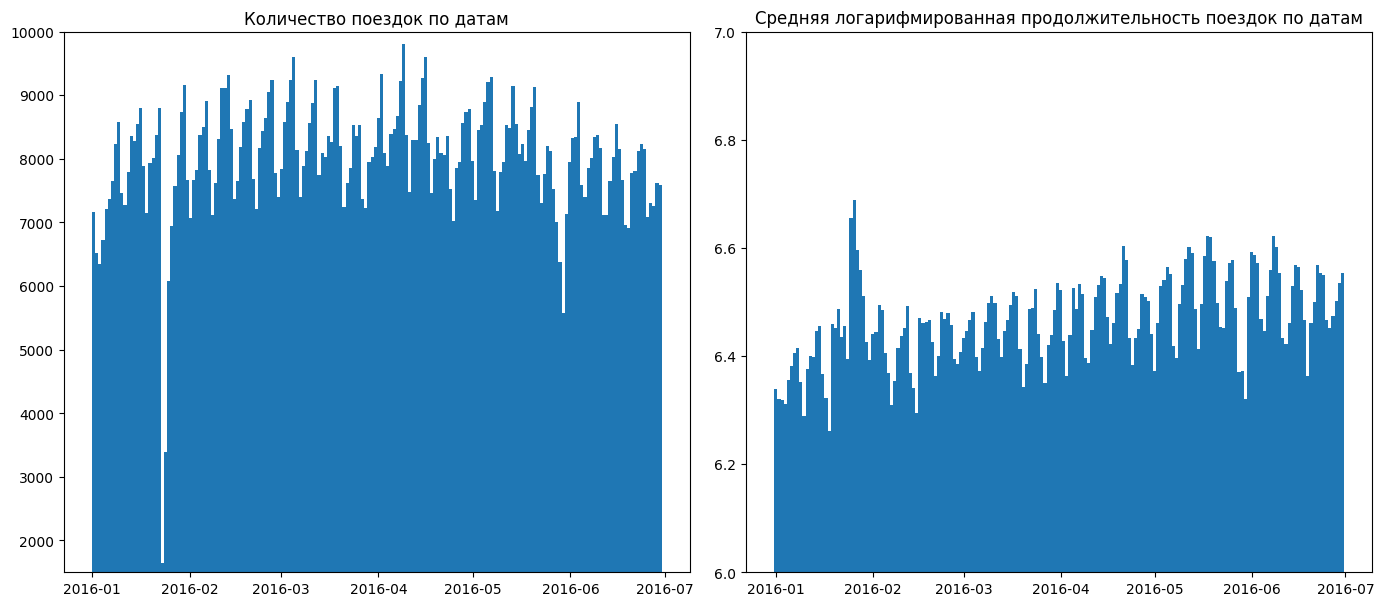

In [36]:
import matplotlib.pyplot as plt

fig = plt.figure()

fig.set_size_inches(14, 6)

ax_1 = fig.add_subplot(1, 2, 1)
plt.hist(data['date'], bins=data['date'].unique().shape[0])
plt.ylim(1500, 10000)

ax_2 = fig.add_subplot(1, 2, 2)
plt.bar(sorted(list(data['date'].unique())), data.groupby(
    'date')['log_trip_duration'].mean(), width=1)
plt.ylim(6, 7)

fig.tight_layout()

ax_1.set(title='Количество поездок по датам')
ax_2.set(title='Средняя логарифмированная продолжительность поездок по датам')

plt.show()

Наблюдается спад количества поездок и рост продолжительности поездки в конце января. Это связано с тем, что в это время был аномальный снегопад. В будущем можем добавить бинарный признак "произошла ли поездка в аномальную погоду"


Исследуем зависимость таргета от дня недели и времени дня


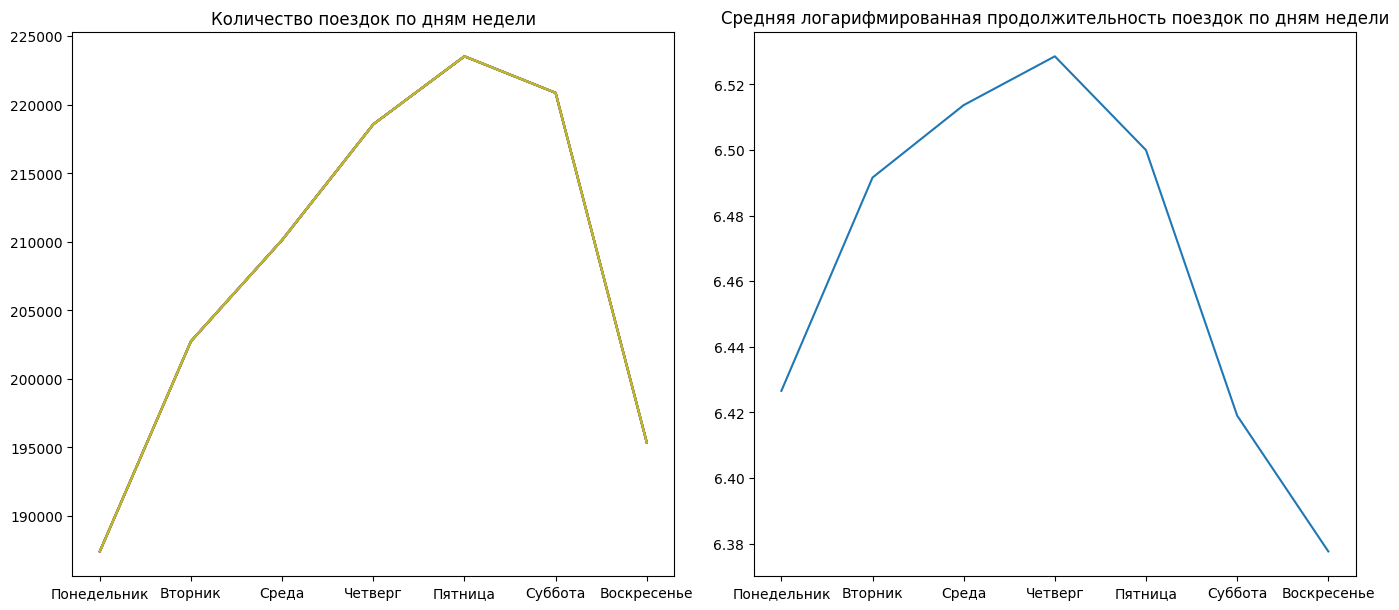

In [44]:
# Построим графики количества поездок и таргета по дням недели

fig = plt.figure()

fig.set_size_inches(14, 6)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(data.groupby('day_of_week').count())
plt.xticks(ticks=range(7), labels=['Понедельник', 'Вторник', 'Среда',
           'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(data.groupby('day_of_week')['log_trip_duration'].mean())
plt.xticks(ticks=range(7), labels=['Понедельник', 'Вторник', 'Среда',
           'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])

fig.tight_layout()

ax_1.set(title = 'Количество поездок по дням недели')
ax_2.set(title = 'Средняя логарифмированная продолжительность поездок по дням недели')

plt.show()

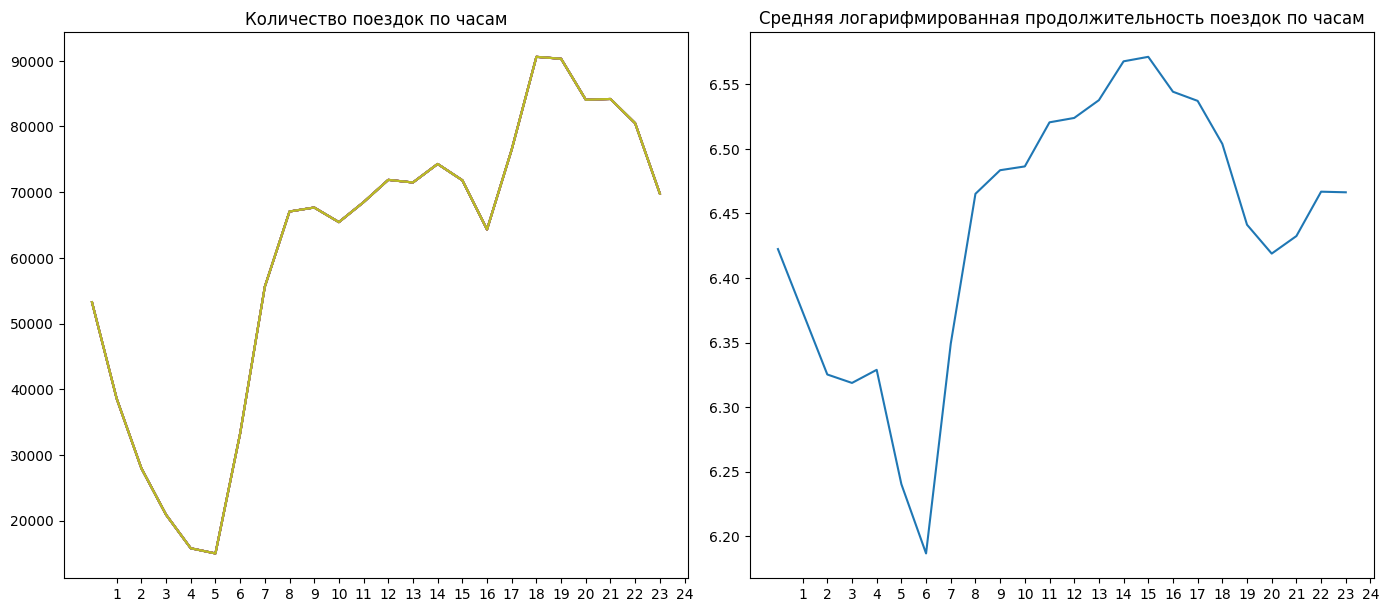

In [46]:
# Построим графики количества поездок и таргета по часам

fig = plt.figure()

fig.set_size_inches(14, 6)

ax_1 = fig.add_subplot(1, 2, 1)
plt.plot(data.groupby('hour').count())
plt.xticks(ticks=range(1, 25))

ax_2 = fig.add_subplot(1, 2, 2)
plt.plot(data.groupby('hour')['log_trip_duration'].mean())
plt.xticks(ticks=range(1, 25))

fig.tight_layout()

ax_1.set(title = 'Количество поездок по часам')
ax_2.set(title = 'Средняя логарифмированная продолжительность поездок по часам')

plt.show()

Видно, что количество поездок в определенный промежуток времени и соответствующее этому промежутку среднее значение таргета сильно и положительно связаны

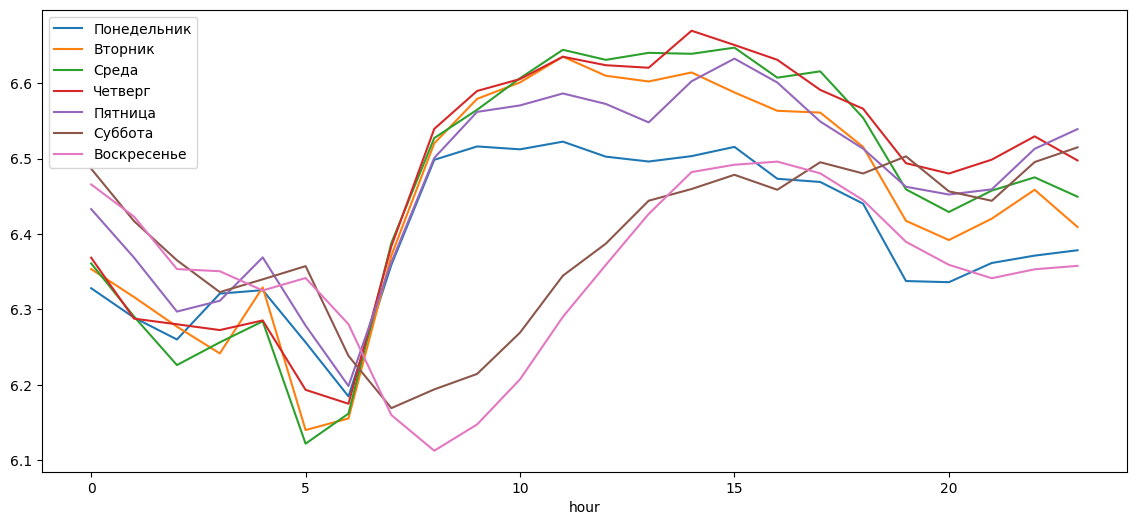

In [64]:
# Построим кривые таргета по часам для каждого дня недели

frame = data.groupby(['day_of_week', 'hour'], as_index=False)['log_trip_duration'].mean()
frame = frame.pivot(index='hour', columns='day_of_week', values='log_trip_duration')
frame.plot(figsize=(14, 6))

plt.legend(['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье'])

plt.show()

Видно, что час-пик почти всегда приходится на рабочие часы в практически любой день недели, в районе 13-15 часов.

In [66]:
# Изобразим в виде тепловой карты  

frame.columns = ['Понедельник', 'Вторник', 'Среда', 
                 'Четверг', 'Пятница', 'Суббота', 
                 'Воскресенье']

frame.style.background_gradient(cmap='RdPu')

,Понедельник,Вторник,Среда,Четверг,Пятница,Суббота,Воскресенье
hour,,,,,,,
0,6.328173,6.353598,6.361024,6.368642,6.433067,6.486600,6.465794
1,6.289221,6.316450,6.290582,6.287852,6.368686,6.417126,6.423073
2,6.260257,6.277271,6.226347,6.280400,6.297224,6.365256,6.353585
3,6.321038,6.241751,6.256435,6.272725,6.311585,6.323040,6.350705
4,6.325626,6.329338,6.284243,6.285450,6.369078,6.339929,6.325216
5,6.256471,6.140184,6.122148,6.193495,6.278671,6.357487,6.341709
6,6.184772,6.155556,6.162004,6.175040,6.198555,6.238505,6.280519
7,6.359147,6.371453,6.388129,6.383752,6.362452,6.169255,6.160052
8,6.498381,6.520274,6.527269,6.539392,6.500891,6.194081,6.112782


Видно, что легче всего на дорогах в утреннее время в районе 5-6 часов (в выходные чуть позже).

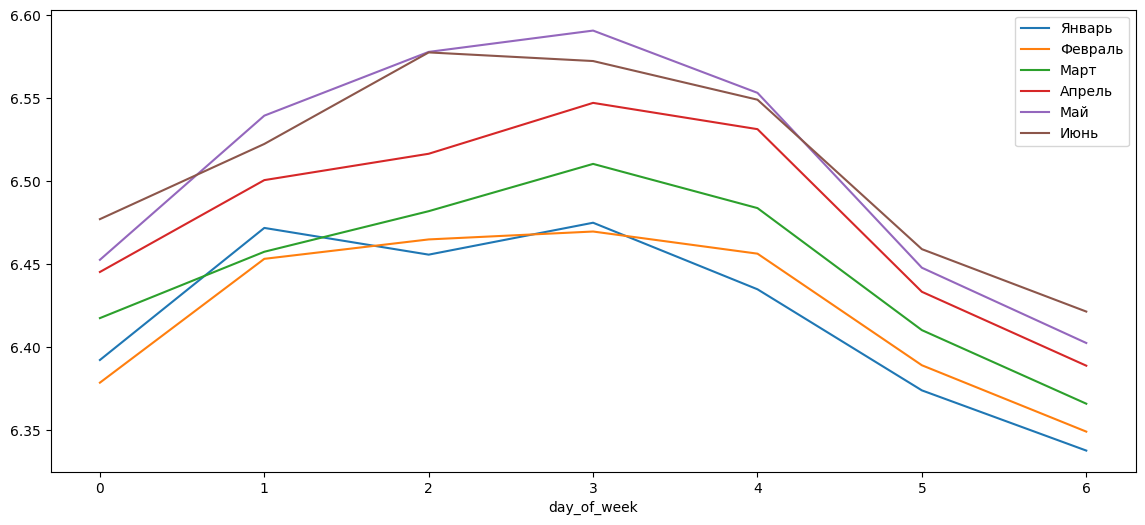

In [70]:
# Сделаем то же самое для каждого месяца по дням недели

frame = data.groupby(['month', 'day_of_week'], as_index=False)['log_trip_duration'].mean()
frame = frame.pivot(index='day_of_week', columns='month', values='log_trip_duration')
frame.plot(figsize=(14, 6))

plt.legend(['Январь', 'Февраль', 'Март', 'Апрель', 'Май', 'Июнь'])

plt.show()

По графику можно понять, что в мае и июне в среднем самые долгие поездки. Также видно, что в зависимости от дня недели средняя длительность поездки меняется

Полученные выводы из графиков выше достаточны для того, чтобы посчитать признаки, связанные с временем/датой поездки, достаточно важными. На их основе выделим еще пару:

1. **anomaly** - была ли в день поездки буря (основываясь на единственном обнаруженном таком дне)
2. **traffic_jam** - является ли время поездки статистически самым проблемным, то есть час пиком?

Для создания 2-ой фичи используем следующую логику: посчитаем для каждой пары "день недели"-"время суток" среднее значение таргета. Найдем топ-10 самых "больших" пар. Если поездка была совершена во входящее в этот топ время, то ставим 1. Иначе - 0. Получим бинарный признак.

In [ ]:
# создадим признак anomaly
# аномальная погода была 23.06.2016

data['anomaly'] = (data['date'].apply(str)=='2016-01-23').astype(int)

In [135]:
# создадим признак traffic_jam

top = data.groupby(['day_of_week', 'hour'], as_index=False)['log_trip_duration'].mean()
top = top.sort_values(by='log_trip_duration', ascending=False)[:10].drop('log_trip_duration', axis=1)
top = list(map(tuple, top.to_records(index=False)))

data['traffic_jam'] = data[['day_of_week', 'hour']].apply(lambda x: tuple(x) in top, axis=1).astype(int)

Теперь уберем колонки **pickup_datetime**, **date** , а оставшиеся **day_of_week**, **hour**, **month** закодируем с помощью OneHotEncoder

In [136]:
data = data.drop(['pickup_datetime', 'date'], axis=1)

In [139]:
data = pd.get_dummies(data, columns=['day_of_week', 'hour', 'month'])

In [141]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_0,day_of_week_1,day_of_week_2,...,hour_20,hour_21,hour_22,hour_23,month_1,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,True,False,False,...,False,False,False,False,False,False,True,False,False,False
id2377394,0,930.399753,0,1.807119,6.498282,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
id3858529,1,930.399753,0,6.392080,7.661527,0,1,False,True,False,...,False,False,False,False,True,False,False,False,False,False
id3504673,1,930.399753,0,1.487155,6.063785,0,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
id2181028,1,930.399753,0,1.189925,6.077642,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False


Проверим, нет ли корреляции между **distance_km** и **passenger_count**, чтобы узнать, есть ли избыток информации

In [142]:
data[['distance_km', 'passenger_count']].corr()

# кореляция близка к 0, избытка информации нет

,distance_km,passenger_count
distance_km,1.000000,0.016596
passenger_count,0.016596,1.000000


Сохраним подготовленные данные


In [143]:
data.head()

,vendor_id,passenger_count,store_and_fwd_flag,distance_km,log_trip_duration,anomaly,traffic_jam,day_of_week_0,day_of_week_1,day_of_week_2,...,hour_20,hour_21,hour_22,hour_23,month_1,month_2,month_3,month_4,month_5,month_6
id,,,,,,,,,,,,,,,,,,,,,
id2875421,1,930.399753,0,1.500479,6.122493,0,0,True,False,False,...,False,False,False,False,False,False,True,False,False,False
id2377394,0,930.399753,0,1.807119,6.498282,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
id3858529,1,930.399753,0,6.392080,7.661527,0,1,False,True,False,...,False,False,False,False,True,False,False,False,False,False
id3504673,1,930.399753,0,1.487155,6.063785,0,0,False,False,True,...,False,False,False,False,False,False,False,True,False,False
id2181028,1,930.399753,0,1.189925,6.077642,0,0,False,False,False,...,False,False,False,False,False,False,True,False,False,False


In [144]:
data.to_csv('output/processed_data.csv', sep=';')